# Flip 7 Strategy Simulation & Analysis

This notebook provides a complete workflow for:
1. Defining and configuring strategies
2. Running large-scale simulations
3. Exporting results to CSV/JSON
4. Statistical analysis and visualization
5. Head-to-head comparisons and significance testing

## Prerequisites

Ensure simulation dependencies are installed:
```bash
pip install -e ".[simulation]"
```

---
## 1. Setup & Imports

In [1]:
# Auto-reload modules when they change (useful during development)
%load_ext autoreload
%autoreload 2

# Core simulation imports
from flip_7.simulation.runner import SimulationRunner
from flip_7.simulation.exporter import SimulationExporter
from flip_7.simulation.strategies import RandomStrategy, ThresholdStrategy

# Analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# tqdm is optional - SimulationRunner will auto-detect and use it if available
# If you want to use custom progress callbacks, uncomment:
# from tqdm.notebook import tqdm

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✓ All imports successful")

✓ All imports successful


---
## 2. Define Strategies

Configure the strategies you want to test. You can add your own custom strategies here.

In [2]:
# Define strategies to test
strategies = [
    RandomStrategy(name="Random_50", hit_probability=0.5, seed=1),
    ThresholdStrategy(name="Threshold_21", target_score=21),
    ThresholdStrategy(name="Threshold_25", target_score=25),
    ThresholdStrategy(name="Threshold_30", target_score=30),
]

print("Strategies to test:")
for s in strategies:
    print(f"  - {s.name}")

Strategies to test:
  - Random_50
  - Threshold_21
  - Threshold_25
  - Threshold_30


---
## 3. Run Simulation

Run a batch of simulated games. Adjust `NUM_GAMES` based on your needs:
- 1,000 games: Quick test (~10 seconds)
- 10,000 games: Good statistics (~1-2 minutes)
- 100,000 games: Robust results (~10-15 minutes)

In [3]:
# Simulation configuration
NUM_GAMES = 10000      # Number of games to simulate
NUM_PLAYERS = len(strategies)       # Players per game
RANDOM_SEED = 42       # For reproducibility

In [4]:
# Create simulation runner
runner = SimulationRunner(
    strategies=strategies,
    num_players=NUM_PLAYERS,
    seed=RANDOM_SEED,
    verbose=False  # Set to True for progress messages every 100 games
)

# Run simulation with built-in progress bar
print(f"\nRunning {NUM_GAMES:,} simulated games...\n")

# Option 1: Built-in progress bar (recommended - auto-detects Jupyter)
results = runner.run_simulation(
    num_games=NUM_GAMES,
    show_progress=True  # Automatically uses tqdm.notebook in Jupyter
)

print("\n✓ Simulation complete!")


Running 10,000 simulated games...



Simulating games:   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Simulation complete!


---
## 4. Quick Results Summary

In [5]:
print("="*70)
print("SIMULATION RESULTS")
print("="*70)
print(f"\nTotal Games: {results.total_games:,}\n")
print("Strategy Performance:")
print(f"{'Strategy':<25} {'Games':>8} {'Wins':>8} {'Win Rate':>10} {'Avg Score':>12}")
print("-" * 70)

sorted_stats = sorted(
    results.strategy_stats.items(),
    key=lambda x: x[1].win_rate,
    reverse=True
)

for name, stats in sorted_stats:
    print(f"{name:<25} {stats.games_played:>8,} {stats.wins:>8,} "
          f"{stats.win_rate:>9.1%} {stats.avg_score:>12.1f}")

print("-" * 70)
print("\nDetailed Metrics:")
print(f"{'Strategy':<25} {'Flip 7s':>10} {'Busts':>10} {'Avg Rounds':>12}")
print("-" * 70)

for name, stats in sorted_stats:
    flip7_per_game = stats.total_flip_7s / stats.games_played
    bust_per_game = stats.total_busts / stats.games_played
    print(f"{name:<25} {flip7_per_game:>10.2f} {bust_per_game:>10.2f} "
          f"{stats.avg_rounds:>12.1f}")

print("="*70)

SIMULATION RESULTS

Total Games: 10,000

Strategy Performance:
Strategy                     Games     Wins   Win Rate    Avg Score
----------------------------------------------------------------------
Threshold_30                10,000    3,803     38.0%        179.6
Threshold_25                10,000    3,616     36.2%        181.4
Threshold_21                10,000    2,580     25.8%        176.0
Random_50                   10,000        1      0.0%         53.0
----------------------------------------------------------------------

Detailed Metrics:
Strategy                     Flip 7s      Busts   Avg Rounds
----------------------------------------------------------------------
Threshold_30                    0.02       3.52          9.3
Threshold_25                    0.01       2.70          9.3
Threshold_21                    0.01       2.01          9.3
Random_50                       0.01       0.48          9.3


---
## 5. Export Results

Export to CSV (for pandas analysis) and JSON (for detailed exploration).

In [6]:
# Create exporter
exporter = SimulationExporter(output_dir="simulation_results")

# Export all formats
files = exporter.export_all(results, filename_prefix="simulation")

print("Exported files:")
for format_name, filepath in files.items():
    print(f"  {format_name}: {filepath}")

# Load CSV for detailed analysis
df = pd.read_csv(files['csv'])
print(f"\n✓ Loaded {len(df):,} player records from {df['game_id'].nunique():,} games")

Exported files:
  csv: simulation_results/simulation_20251106_211512.csv
  json: simulation_results/simulation_20251106_211512.json
  summary: simulation_results/simulation_20251106_211513.txt

✓ Loaded 40,000 player records from 10,000 games


---
## 6. Statistical Analysis

### 6.1 Overall Statistics

In [7]:
# Strategy-level aggregation
strategy_stats = df.groupby('strategy').agg({
    'won_game': ['sum', 'mean', 'count'],
    'final_score': ['mean', 'std', 'median', 'min', 'max'],
    'flip_7_count': 'sum',
    'bust_count': 'sum',
    'avg_round_score': 'mean',
    'total_rounds': 'mean'
}).round(2)

strategy_stats.columns = ['_'.join(col).strip() for col in strategy_stats.columns.values]
strategy_stats = strategy_stats.rename(columns={
    'won_game_sum': 'total_wins',
    'won_game_mean': 'win_rate',
    'won_game_count': 'games_played',
    'final_score_mean': 'avg_score',
    'final_score_std': 'score_std',
    'final_score_median': 'median_score',
    'final_score_min': 'min_score',
    'final_score_max': 'max_score',
    'flip_7_count_sum': 'total_flip_7s',
    'bust_count_sum': 'total_busts',
    'avg_round_score_mean': 'avg_round_score',
    'total_rounds_mean': 'avg_game_length'
})

strategy_stats = strategy_stats.sort_values('win_rate', ascending=False)
print("\nComprehensive Strategy Statistics:")
strategy_stats


Comprehensive Strategy Statistics:


,total_wins,win_rate,games_played,avg_score,score_std,median_score,min_score,max_score,total_flip_7s,total_busts,avg_round_score,avg_game_length
strategy,,,,,,,,,,,,
Threshold_30,3803,0.38,10000,179.65,40.72,191.0,0,292,236,35178,19.85,9.26
Threshold_25,3616,0.36,10000,181.45,36.90,192.0,0,280,115,27007,19.91,9.26
Threshold_21,2580,0.26,10000,175.95,35.23,181.0,23,278,60,20082,19.17,9.26
Random_50,1,0.00,10000,53.01,28.21,49.0,0,217,93,4811,5.73,9.26


### 6.2 Win Rate Visualization

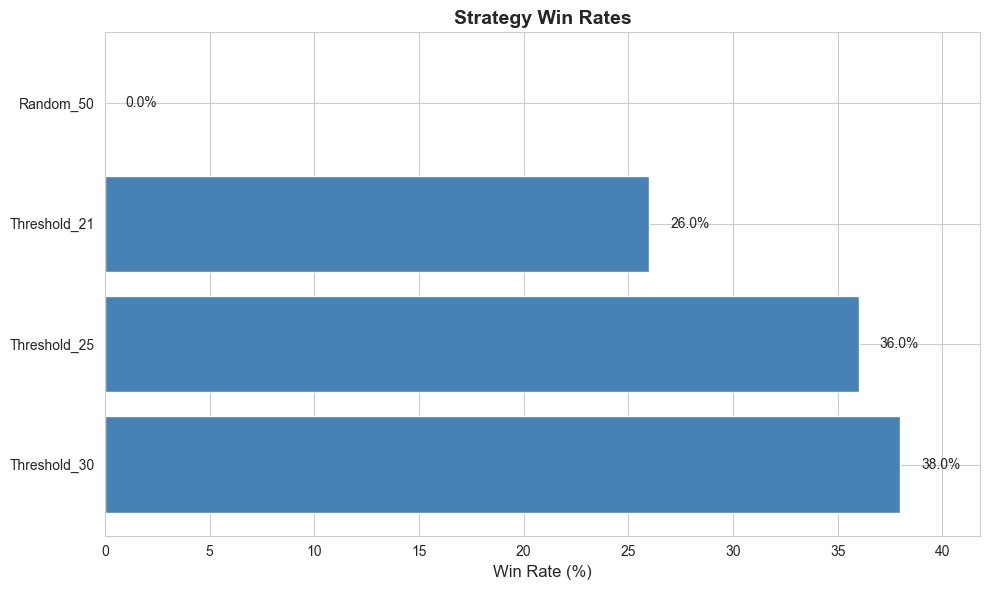

In [8]:
# Win rate bar chart
fig, ax = plt.subplots(figsize=(10, 6))

strategies_list = strategy_stats.index
win_rates = strategy_stats['win_rate'] * 100

bars = ax.barh(strategies_list, win_rates, color='steelblue')
ax.set_xlabel('Win Rate (%)', fontsize=12)
ax.set_title('Strategy Win Rates', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(win_rates) * 1.1)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%',
            ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 6.3 Score Distributions

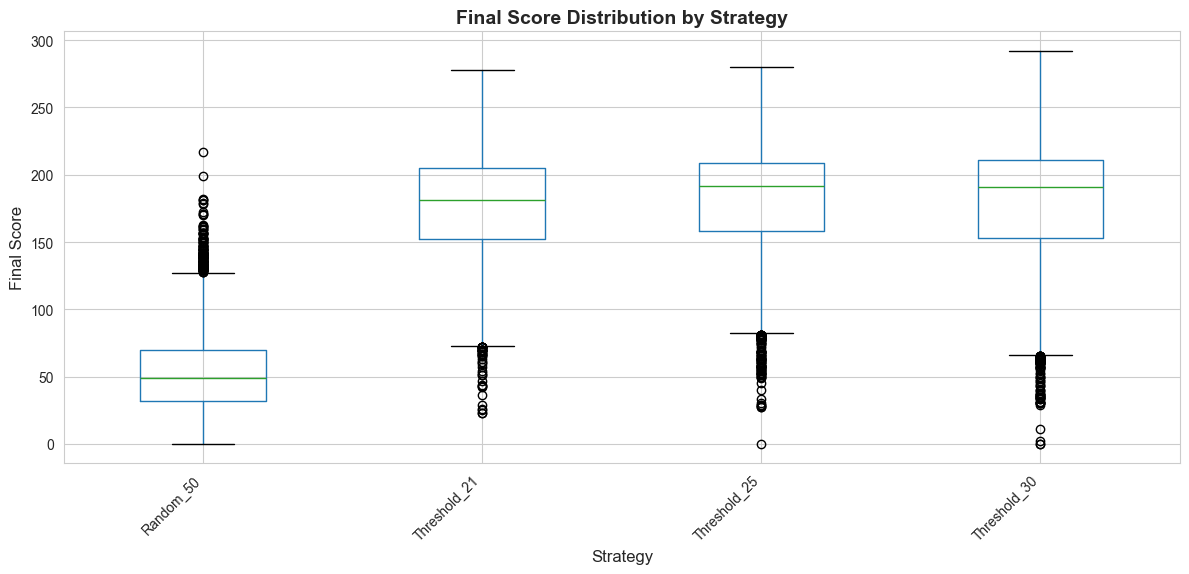

In [9]:
# Box plot of final scores
fig, ax = plt.subplots(figsize=(12, 6))

df.boxplot(column='final_score', by='strategy', ax=ax)
ax.set_title('Final Score Distribution by Strategy', fontsize=14, fontweight='bold')
ax.set_xlabel('Strategy', fontsize=12)
ax.set_ylabel('Final Score', fontsize=12)
plt.suptitle('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

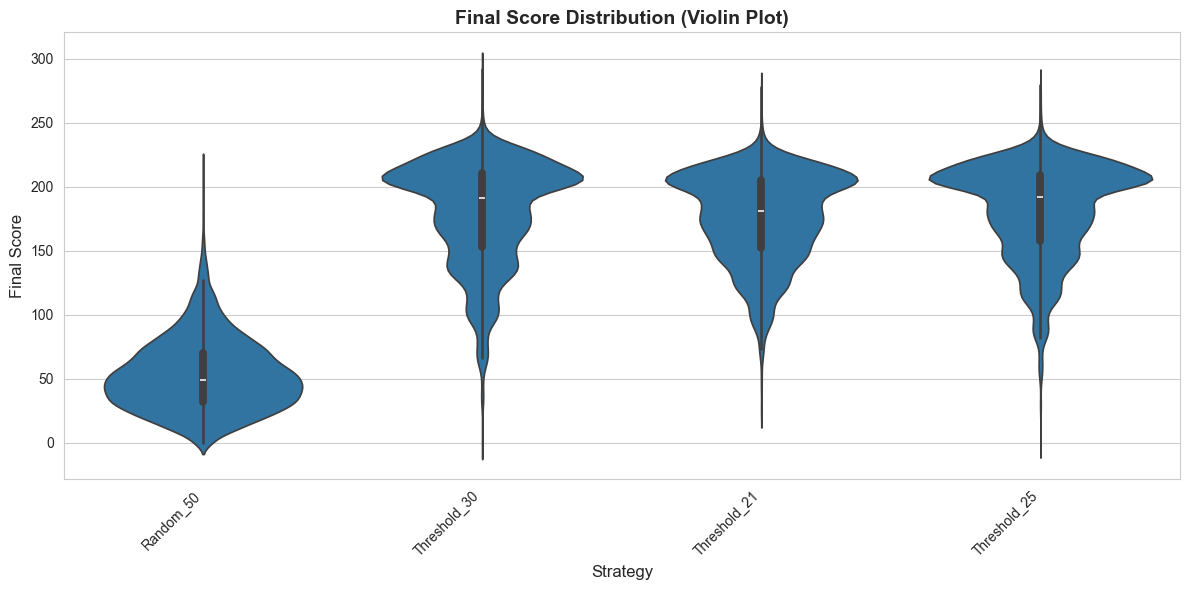

In [10]:
# Violin plot for detailed distribution
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(data=df, x='strategy', y='final_score', ax=ax)
ax.set_title('Final Score Distribution (Violin Plot)', fontsize=14, fontweight='bold')
ax.set_xlabel('Strategy', fontsize=12)
ax.set_ylabel('Final Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6.4 Flip 7 and Bust Analysis

In [11]:
# Calculate rates
flip7_bust_stats = df.groupby('strategy').agg({
    'flip_7_count': ['sum', 'mean'],
    'bust_count': ['sum', 'mean'],
}).round(3)

flip7_bust_stats.columns = ['total_flip7', 'flip7_per_game', 'total_busts', 'busts_per_game']
print("\nFlip 7 and Bust Statistics:")
print(flip7_bust_stats)


Flip 7 and Bust Statistics:
              total_flip7  flip7_per_game  total_busts  busts_per_game
strategy                                                              
Random_50              93           0.009         4811           0.481
Threshold_21           60           0.006        20082           2.008
Threshold_25          115           0.012        27007           2.701
Threshold_30          236           0.024        35178           3.518


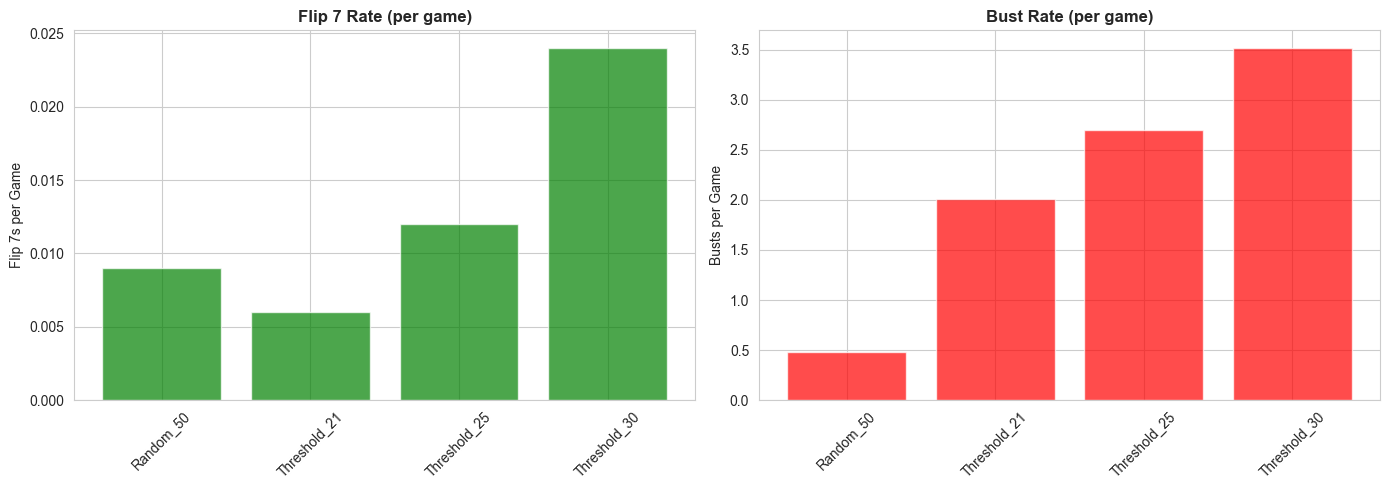

In [12]:
# Plot flip 7 vs bust rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strategies_list = flip7_bust_stats.index
flip7_rate = flip7_bust_stats['flip7_per_game']
bust_rate = flip7_bust_stats['busts_per_game']

# Flip 7 rate
axes[0].bar(strategies_list, flip7_rate, color='green', alpha=0.7)
axes[0].set_title('Flip 7 Rate (per game)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Flip 7s per Game', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Bust rate
axes[1].bar(strategies_list, bust_rate, color='red', alpha=0.7)
axes[1].set_title('Bust Rate (per game)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Busts per Game', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 6.5 Game Length Analysis

Game Length Statistics:
  Average: 9.3 rounds
  Median: 9 rounds
  Min/Max: 5 / 17 rounds


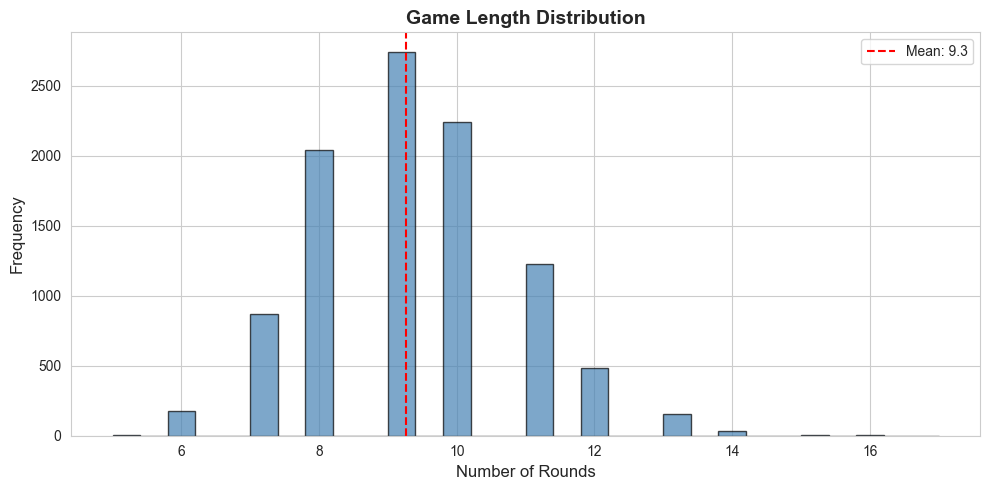

In [13]:
# Analyze game lengths
game_lengths = df.groupby('game_id')['total_rounds'].first()

print(f"Game Length Statistics:")
print(f"  Average: {game_lengths.mean():.1f} rounds")
print(f"  Median: {game_lengths.median():.0f} rounds")
print(f"  Min/Max: {game_lengths.min():.0f} / {game_lengths.max():.0f} rounds")

# Histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(game_lengths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of Rounds', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Game Length Distribution', fontsize=14, fontweight='bold')
ax.axvline(game_lengths.mean(), color='red', linestyle='--',
           label=f'Mean: {game_lengths.mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 7. Head-to-Head Comparison

For 2-player games, show head-to-head win rates.

In [14]:
# Check if 2-player games
players_per_game = df.groupby('game_id').size().iloc[0]

if players_per_game == 2:
    # Build head-to-head matrix
    strategies_list = df['strategy'].unique()
    h2h_matrix = pd.DataFrame(0, index=strategies_list, columns=strategies_list, dtype=float)

    for game_id in df['game_id'].unique():
        game_data = df[df['game_id'] == game_id]

        if len(game_data) == 2:
            players = game_data.to_dict('records')
            p1, p2 = players[0], players[1]

            if p1['won_game'] == 1:
                h2h_matrix.loc[p1['strategy'], p2['strategy']] += 1
            elif p2['won_game'] == 1:
                h2h_matrix.loc[p2['strategy'], p1['strategy']] += 1

    # Convert to win percentages
    h2h_pct = h2h_matrix.copy()
    for i in h2h_matrix.index:
        for j in h2h_matrix.columns:
            if i != j:
                total = h2h_matrix.loc[i, j] + h2h_matrix.loc[j, i]
                if total > 0:
                    h2h_pct.loc[i, j] = (h2h_matrix.loc[i, j] / total) * 100

    print("\nHead-to-Head Win Rates (row vs column):")
    print(h2h_pct.round(1))

    # Heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(h2h_pct, annot=True, fmt='.1f', cmap='RdYlGn',
                center=50, vmin=0, vmax=100, ax=ax,
                cbar_kws={'label': 'Win Rate (%)'})
    ax.set_title('Head-to-Head Win Rate Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"Head-to-head matrix only available for 2-player games (this has {players_per_game} players)")

Head-to-head matrix only available for 2-player games (this has 4 players)


---
## 8. Statistical Significance Testing

Test whether observed differences are statistically significant.

In [15]:
def compare_strategies(df, strategy_a, strategy_b):
    """
    Compare two strategies using statistical tests.
    """
    # Import here to avoid naming conflicts
    from scipy import stats as scipy_stats
    
    data_a = df[df['strategy'] == strategy_a]
    data_b = df[df['strategy'] == strategy_b]

    print(f"\n{'='*60}")
    print(f"Comparing: {strategy_a} vs {strategy_b}")
    print(f"{'='*60}")

    # Win rate comparison
    win_rate_a = data_a['won_game'].mean()
    win_rate_b = data_b['won_game'].mean()

    print(f"\nWin Rates:")
    print(f"  {strategy_a}: {win_rate_a:.1%}")
    print(f"  {strategy_b}: {win_rate_b:.1%}")
    print(f"  Difference: {abs(win_rate_a - win_rate_b):.1%}")

    # Chi-square test for win rates
    wins_a = data_a['won_game'].sum()
    losses_a = len(data_a) - wins_a
    wins_b = data_b['won_game'].sum()
    losses_b = len(data_b) - wins_b

    contingency_table = [[wins_a, losses_a], [wins_b, losses_b]]
    chi2, p_value, dof, expected = scipy_stats.chi2_contingency(contingency_table)

    print(f"\nChi-Square Test (Win Rates):")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant at α=0.05? {'Yes' if p_value < 0.05 else 'No'}")

    # T-test for final scores
    scores_a = data_a['final_score']
    scores_b = data_b['final_score']

    t_stat, t_pvalue = scipy_stats.ttest_ind(scores_a, scores_b)

    print(f"\nAverage Scores:")
    print(f"  {strategy_a}: {scores_a.mean():.1f} (±{scores_a.std():.1f})")
    print(f"  {strategy_b}: {scores_b.mean():.1f} (±{scores_b.std():.1f})")

    print(f"\nT-Test (Final Scores):")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {t_pvalue:.6f}")
    print(f"  Significant at α=0.05? {'Yes' if t_pvalue < 0.05 else 'No'}")

    return {
        'win_rate_diff': abs(win_rate_a - win_rate_b),
        'win_rate_pvalue': p_value,
        'score_pvalue': t_pvalue,
        'significant': p_value < 0.05 or t_pvalue < 0.05
    }

In [16]:
# Compare all pairs of strategies
strategies_list = df['strategy'].unique()

for i in range(len(strategies_list)):
    for j in range(i + 1, len(strategies_list)):
        compare_strategies(df, strategies_list[i], strategies_list[j])


Comparing: Random_50 vs Threshold_30

Win Rates:
  Random_50: 0.0%
  Threshold_30: 38.0%
  Difference: 38.0%

Chi-Square Test (Win Rates):
  Chi-square statistic: 4690.0498
  P-value: 0.000000
  Significant at α=0.05? Yes

Average Scores:
  Random_50: 53.0 (±28.2)
  Threshold_30: 179.6 (±40.7)

T-Test (Final Scores):
  T-statistic: -255.6331
  P-value: 0.000000
  Significant at α=0.05? Yes

Comparing: Random_50 vs Threshold_21

Win Rates:
  Random_50: 0.0%
  Threshold_21: 25.8%
  Difference: 25.8%

Chi-Square Test (Win Rates):
  Chi-square statistic: 2956.5457
  P-value: 0.000000
  Significant at α=0.05? Yes

Average Scores:
  Random_50: 53.0 (±28.2)
  Threshold_21: 176.0 (±35.2)

T-Test (Final Scores):
  T-statistic: -272.3864
  P-value: 0.000000
  Significant at α=0.05? Yes

Comparing: Random_50 vs Threshold_25

Win Rates:
  Random_50: 0.0%
  Threshold_25: 36.2%
  Difference: 36.1%

Chi-Square Test (Win Rates):
  Chi-square statistic: 4408.2311
  P-value: 0.000000
  Significant at α

---
## 9. Risk-Reward Analysis

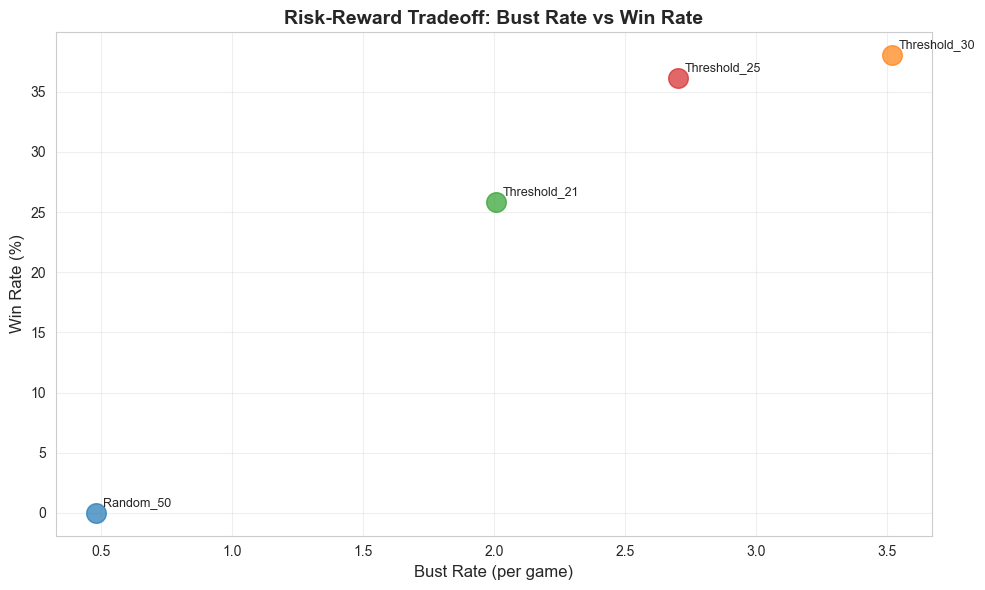

In [17]:
# Plot bust rate vs win rate
fig, ax = plt.subplots(figsize=(10, 6))

for strategy in df['strategy'].unique():
    data = df[df['strategy'] == strategy]

    bust_rate = data['bust_count'].mean()
    win_rate = data['won_game'].mean() * 100

    ax.scatter(bust_rate, win_rate, s=200, alpha=0.7, label=strategy)
    ax.annotate(strategy, (bust_rate, win_rate),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Bust Rate (per game)', fontsize=12)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Risk-Reward Tradeoff: Bust Rate vs Win Rate',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

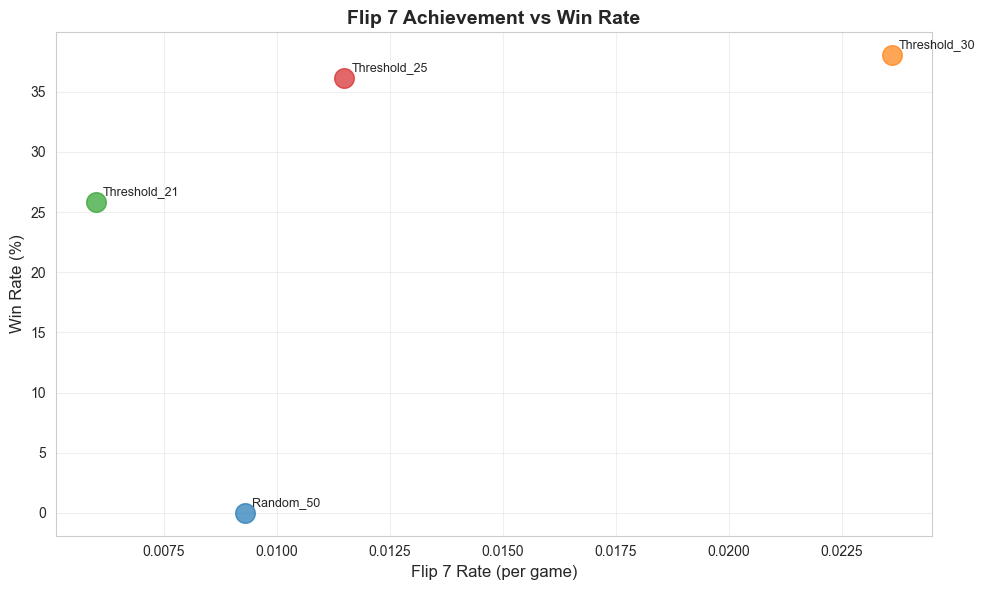

In [18]:
# Plot flip 7 rate vs win rate
fig, ax = plt.subplots(figsize=(10, 6))

for strategy in df['strategy'].unique():
    data = df[df['strategy'] == strategy]

    flip7_rate = data['flip_7_count'].mean()
    win_rate = data['won_game'].mean() * 100

    ax.scatter(flip7_rate, win_rate, s=200, alpha=0.7, label=strategy)
    ax.annotate(strategy, (flip7_rate, win_rate),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Flip 7 Rate (per game)', fontsize=12)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Flip 7 Achievement vs Win Rate',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Conclusions

Document your key findings here:

### Key Findings

**Best Performing Strategy:**
- [Fill in after analysis]
- Win rate: [X%]
- Average score: [Y points]

**Statistical Significance:**
- [Which differences are statistically significant?]
- [Confidence levels?]

**Risk vs Reward:**
- [How do bust rates correlate with win rates?]
- [Is pursuing Flip 7 worth it?]

**Strategy Insights:**
- [What makes the best strategy effective?]
- [What are the weaknesses of other strategies?]

### Recommendations

1. [Should we test additional strategies?]
2. [What threshold values seem optimal?]
3. [Are more simulations needed for robustness?]
4. [What new strategy ideas emerged from this analysis?]